## GANs Theory

Two models:

Generator - trained to generate fake images trying to mimic the training set distribution

Discriminator - is trained to distinguish between actual image from fake image

### What makes it a DCGAN
Convolutional Generator and Discriminator:
Both G and D use convolutional / transposed convolutional layers instead of fully connected ones (except for the latent input).

No Minibatch Discrimination / Attention / Conditional inputs:
It's purely unconditional image generation, no label conditioning, no self-attention, etc.

Binary Cross-Entropy loss:
You're using F.binary_cross_entropy to optimize the original GAN minimax objective:

D maximizes: log(D(x)) + log(1 – D(G(z)))

G minimizes: log(1 – D(G(z))) (or via heuristic:   –log(D(G(z))) as you do)

Manual optimization:
You're explicitly alternating D and G updates, as in the original GAN setup.

### 🧪 Could become one of these with tweaks:
Conditional GAN (cGAN) — If you fed digit labels to both G and D.

Wasserstein GAN (WGAN) — If you swapped BCE loss for a Wasserstein loss and removed the sigmoid from D.

LSGAN (Least Squares GAN) — If you used MSE loss instead of BCE.

InfoGAN / BigGAN / StyleGAN — If you added structured latent codes, attention layers, or progressive growing (which you haven’t).



In [3]:
!pip install -q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00:00:0100:01


In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # ← normalize into [-1, +1]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [6]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent spGANsace input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return torch.tanh(self.conv(x))

### GAN training

In [7]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(64, latent_dim)
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        return [opt_g, opt_d]


    def plot_imgs(self):
      z = self.validation_z.type_as(self.generator.lin1.weight)
      sample_imgs = self(z).cpu()

      print('epoch', self.current_epoch)
      fig = plt.figure()
      print("sample_imgs.size(0)",sample_imgs.size(0))
      for i in range(min(sample_imgs.size(0),6)):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(sample_imgs.detach().numpy()[i,0,:,:], cmap='gray_r', interpolation='none')
        plt.title("Generated Data")
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
      plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()

    def training_step(self, batch, batch_idx):
      real_images, _ = batch
      opt_g, opt_d = self.optimizers()
      batch_size = real_images.size(0)

      # ——— Train Discriminator ———
      # 1. Sample noise and generate fake images
      z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
      fake_images = self(z).detach()

      # 2. Zero grads
      opt_d.zero_grad()

      # 3. Real loss
      y_hat_real = self.discriminator(real_images)
      # optional label smoothing to 0.9
      y_real = torch.ones_like(y_hat_real) * 0.9
      loss_real = self.adversarial_loss(y_hat_real, y_real)

      # 4. Fake loss
      y_hat_fake = self.discriminator(fake_images)
      y_fake = torch.zeros_like(y_hat_fake)
      loss_fake = self.adversarial_loss(y_hat_fake, y_fake)

      # 5. Backward + step
      d_loss = 0.5 * (loss_real + loss_fake)
      self.manual_backward(d_loss)
      opt_d.step()

      # ——— Train Generator ———
      opt_g.zero_grad()

      gen_images = self(z)
      y_hat_gen = self.discriminator(gen_images)
      y_gen = torch.ones_like(y_hat_gen)  # want D(G(z)) → 1
      g_loss = self.adversarial_loss(y_hat_gen, y_gen)

      self.manual_backward(g_loss)
      opt_g.step()

      # ——— Logging ———
      self.log("d_loss", d_loss, on_step=True, on_epoch=True)
      self.log("g_loss", g_loss, on_step=True, on_epoch=True)


In [13]:
data_module = MNISTDataModule()
model = GAN(latent_dim=100, lr=2e-4)

epoch 0
sample_imgs.size(0) 64


/tmp/ipykernel_109/4249161111.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


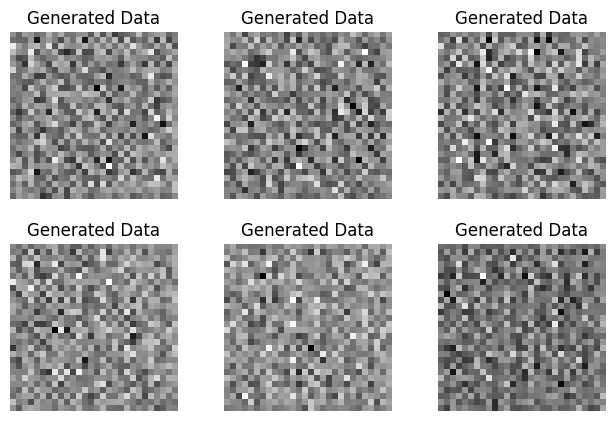

In [14]:
model.plot_imgs()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Training: |          | 0/? [00:00<?, ?it/s]

epoch 0
sample_imgs.size(0) 64


/tmp/ipykernel_109/4249161111.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


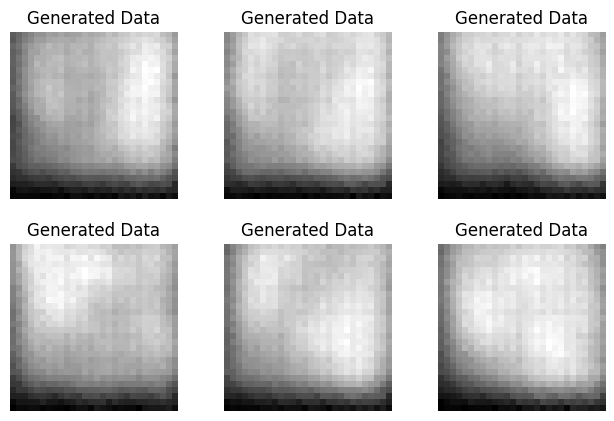

epoch 1
sample_imgs.size(0) 64


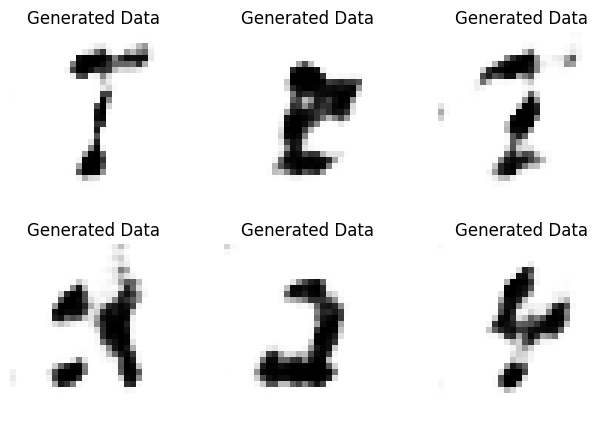

epoch 2
sample_imgs.size(0) 64


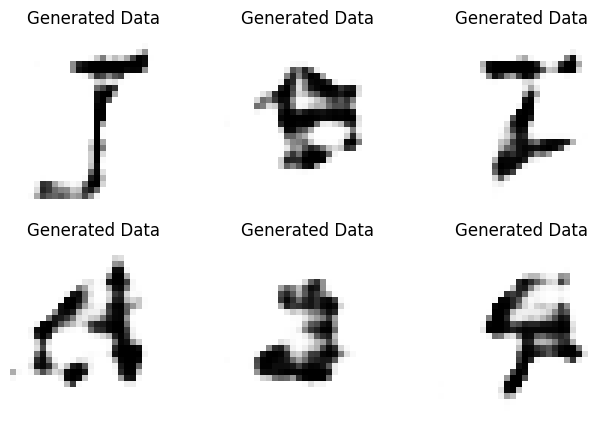

epoch 3
sample_imgs.size(0) 64


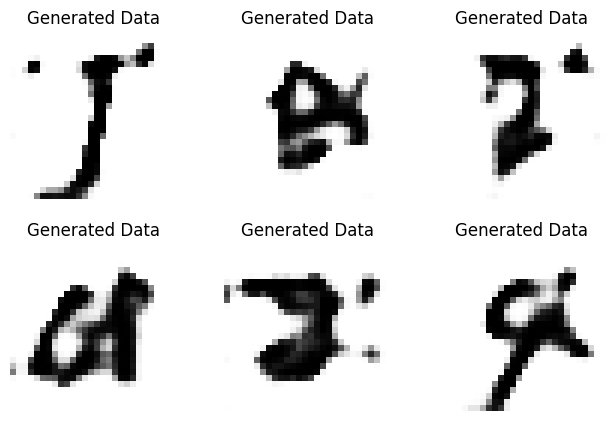

epoch 4
sample_imgs.size(0) 64


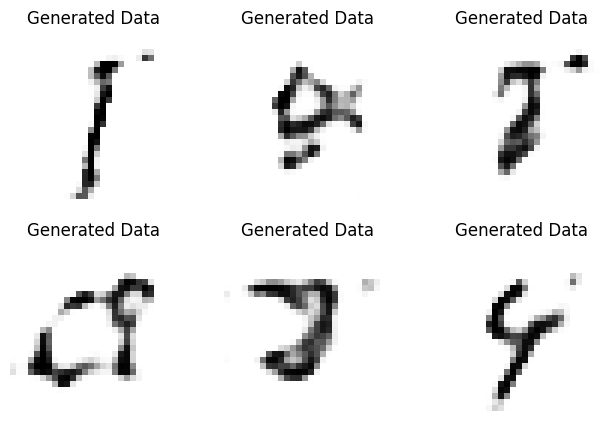

epoch 5
sample_imgs.size(0) 64


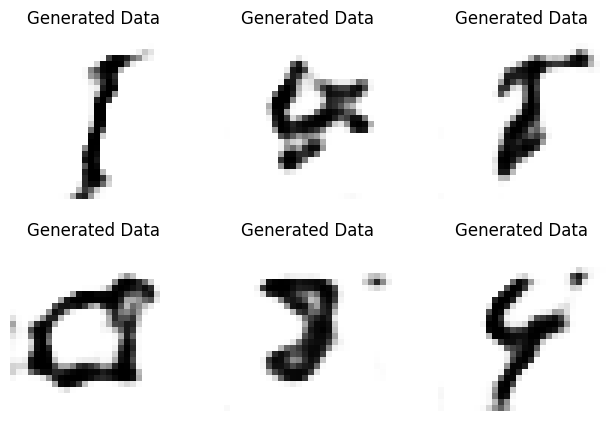

epoch 6
sample_imgs.size(0) 64


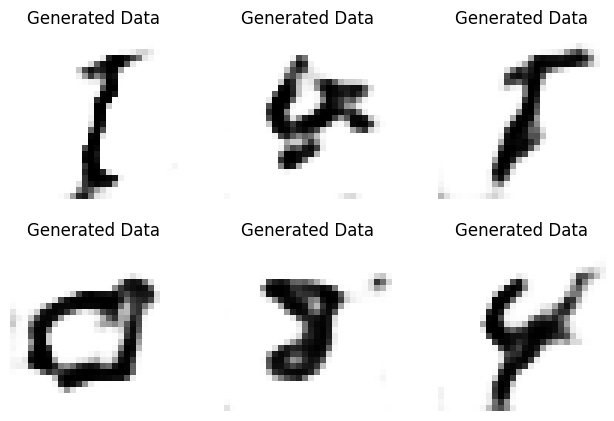

epoch 7
sample_imgs.size(0) 64


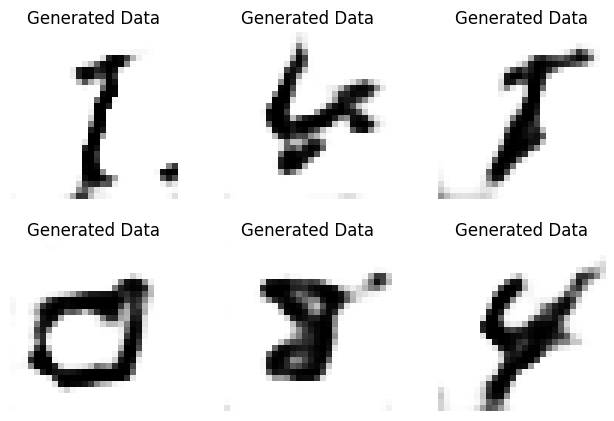

epoch 8
sample_imgs.size(0) 64


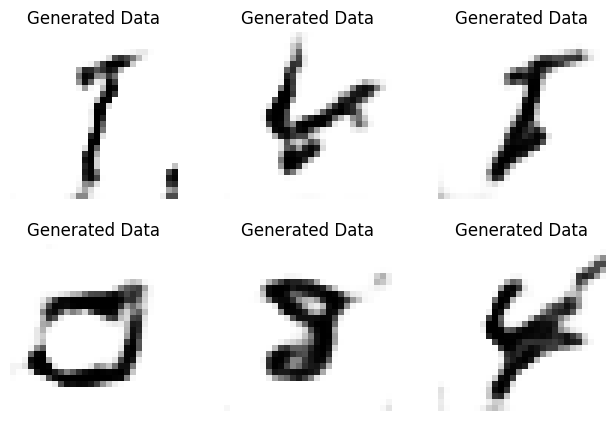

epoch 9
sample_imgs.size(0) 64


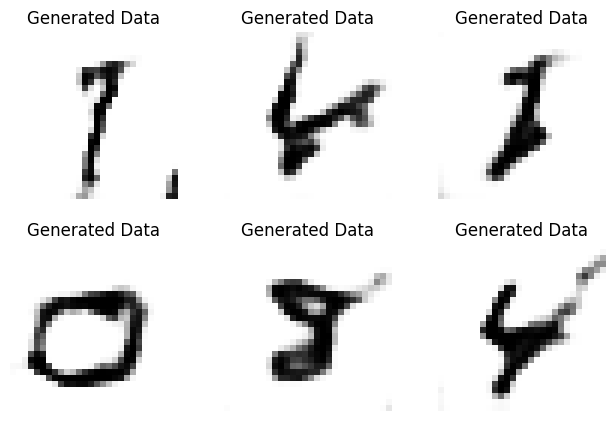

epoch 10
sample_imgs.size(0) 64


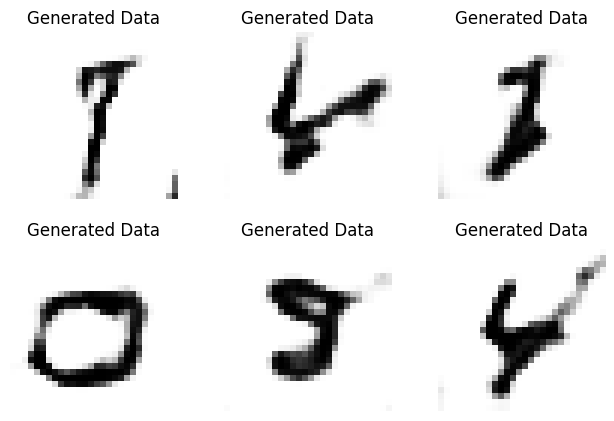

epoch 11
sample_imgs.size(0) 64


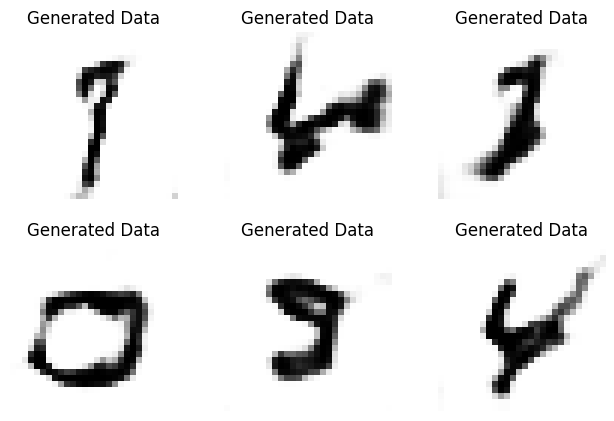

epoch 12
sample_imgs.size(0) 64


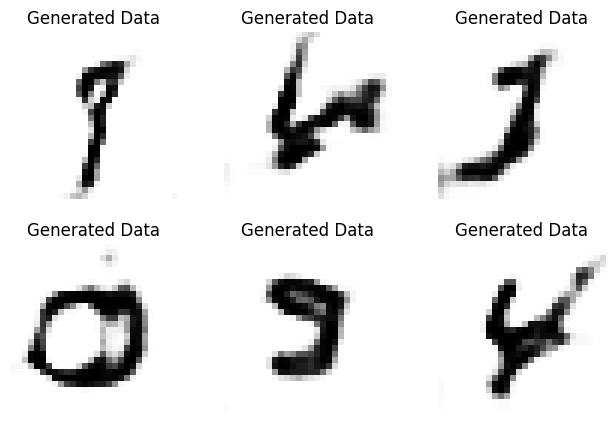

epoch 13
sample_imgs.size(0) 64


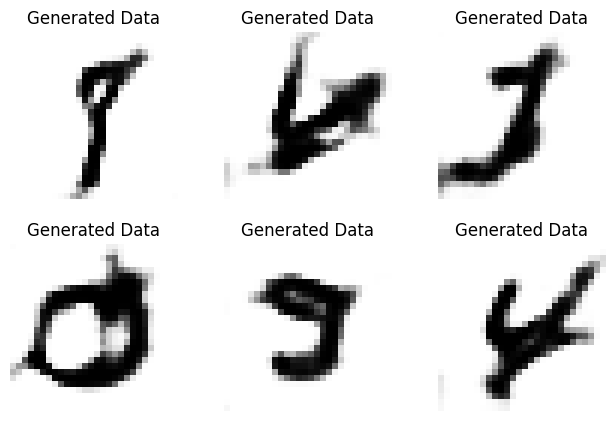

epoch 14
sample_imgs.size(0) 64


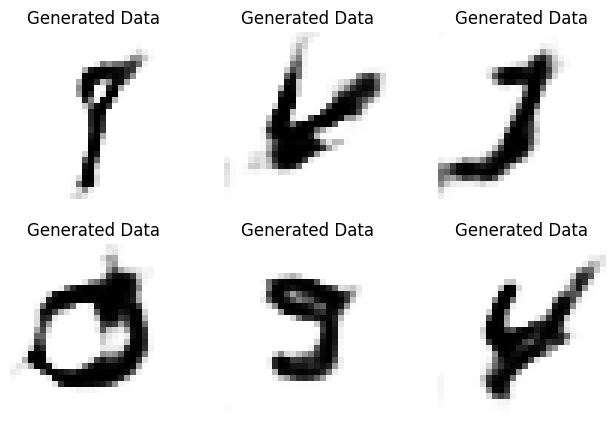

epoch 15
sample_imgs.size(0) 64


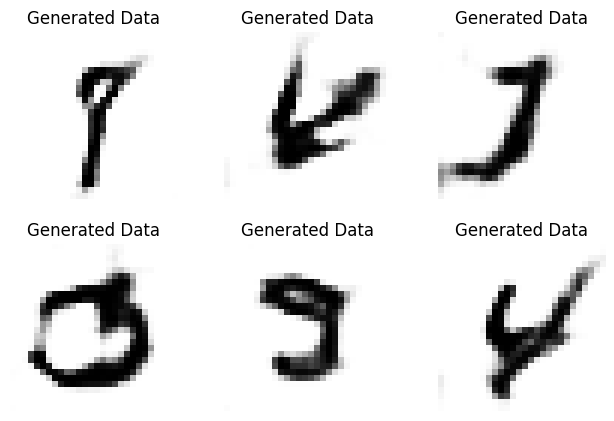

epoch 16
sample_imgs.size(0) 64


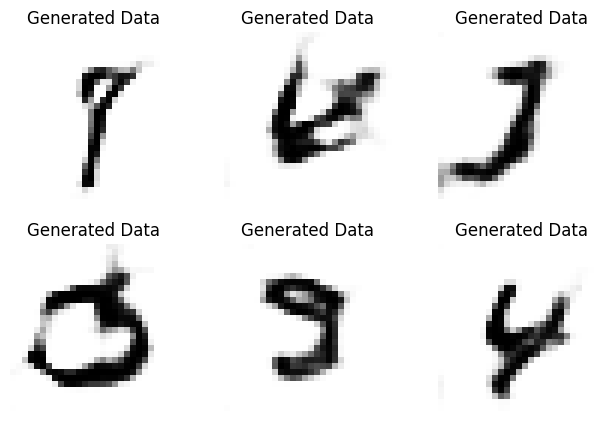

epoch 17
sample_imgs.size(0) 64


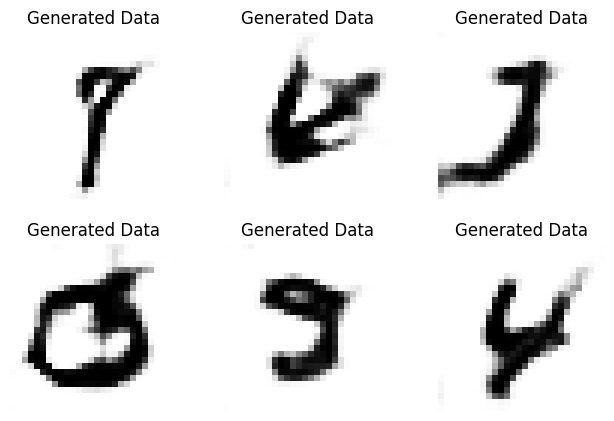

epoch 18
sample_imgs.size(0) 64


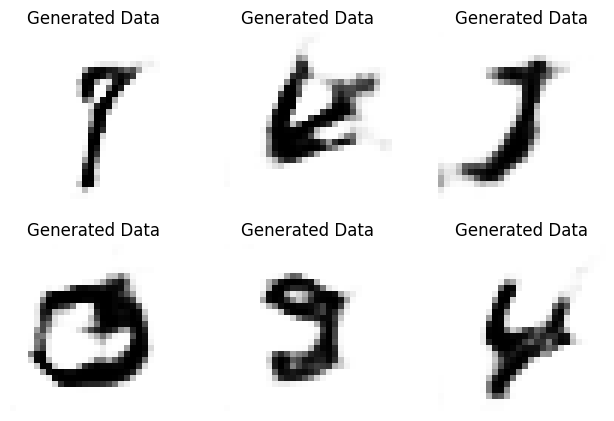

epoch 19
sample_imgs.size(0) 64


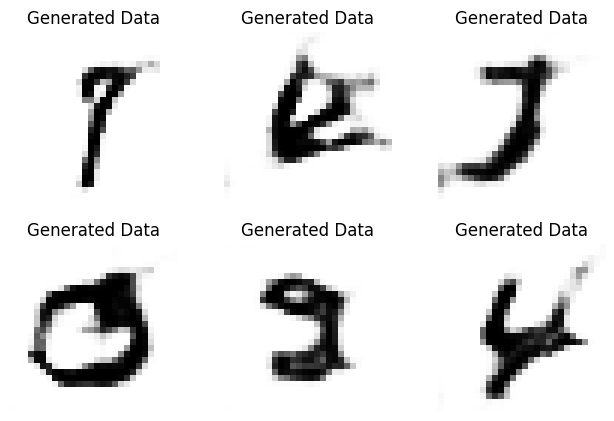

epoch 20
sample_imgs.size(0) 64


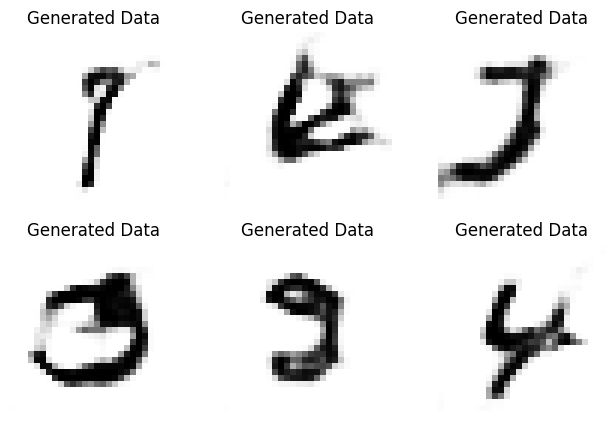

epoch 21
sample_imgs.size(0) 64


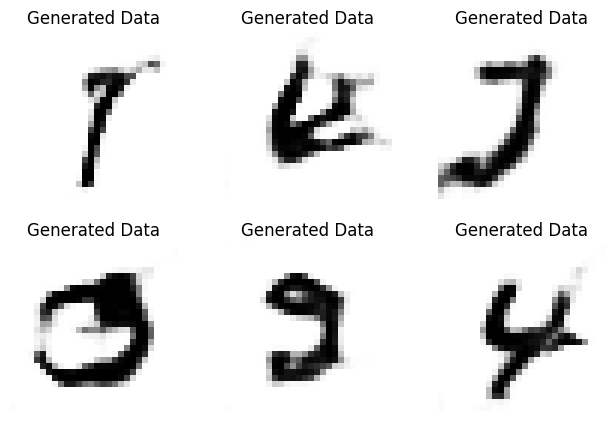

epoch 22
sample_imgs.size(0) 64


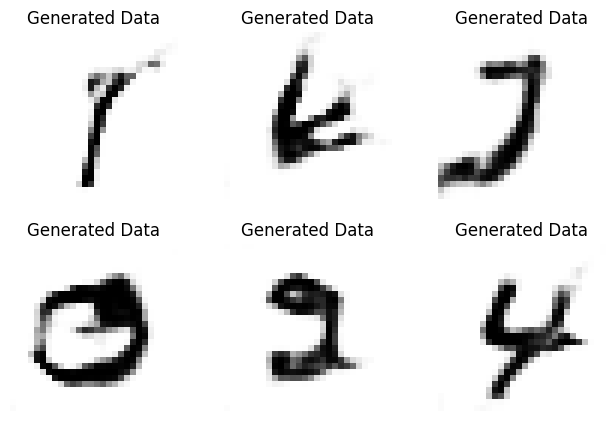

epoch 23
sample_imgs.size(0) 64


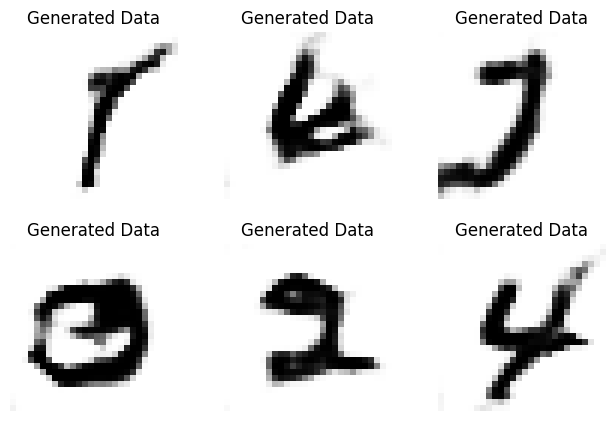

epoch 24
sample_imgs.size(0) 64


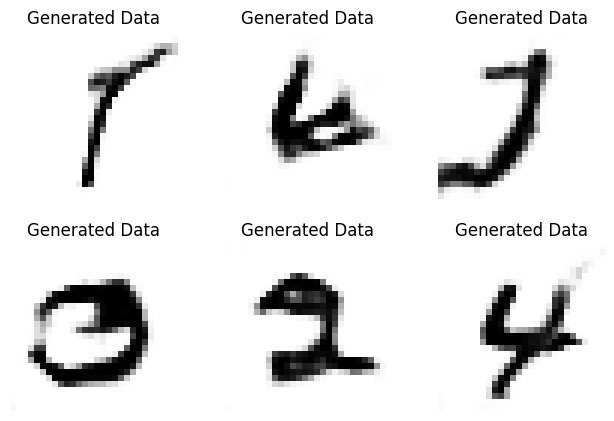

epoch 25
sample_imgs.size(0) 64


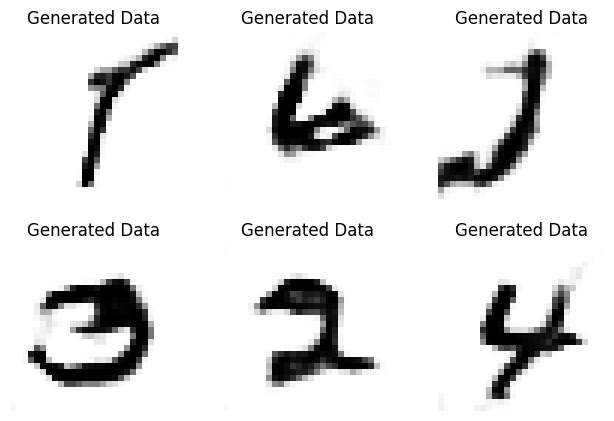

epoch 26
sample_imgs.size(0) 64


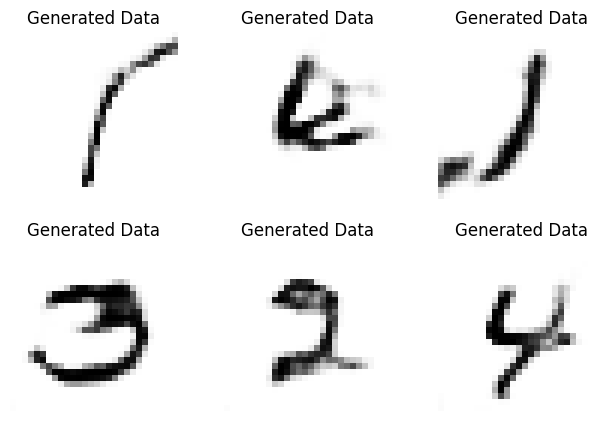

epoch 27
sample_imgs.size(0) 64


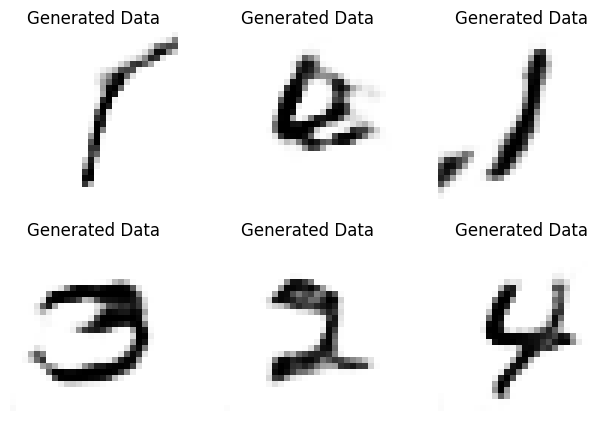

epoch 28
sample_imgs.size(0) 64


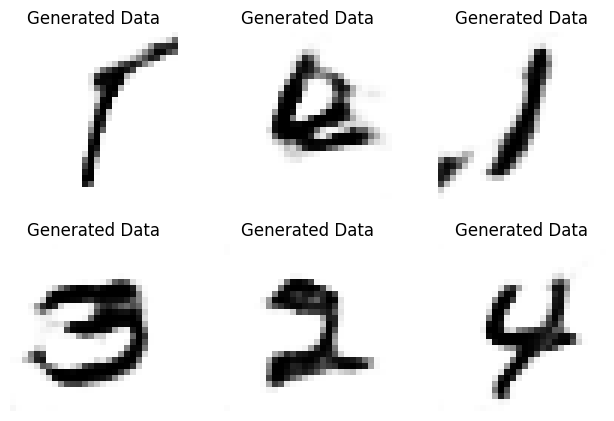

epoch 29
sample_imgs.size(0) 64


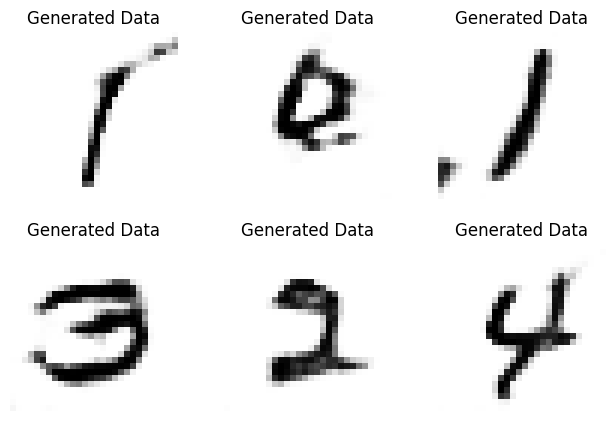

epoch 30
sample_imgs.size(0) 64


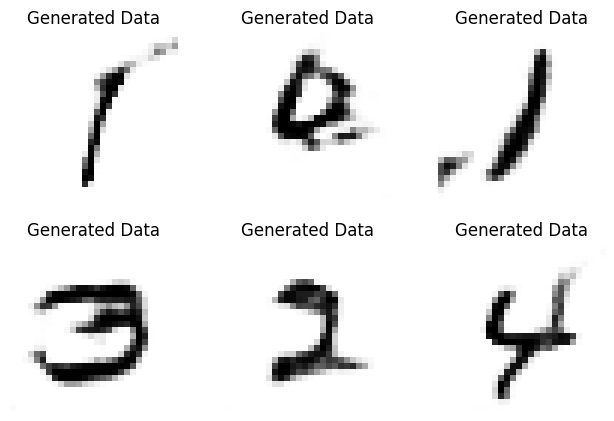

epoch 31
sample_imgs.size(0) 64


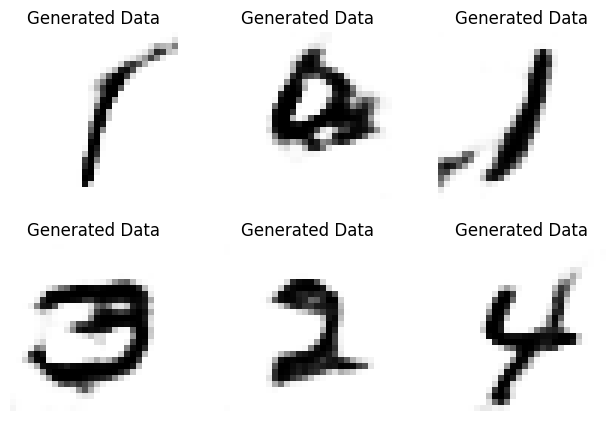

epoch 32
sample_imgs.size(0) 64


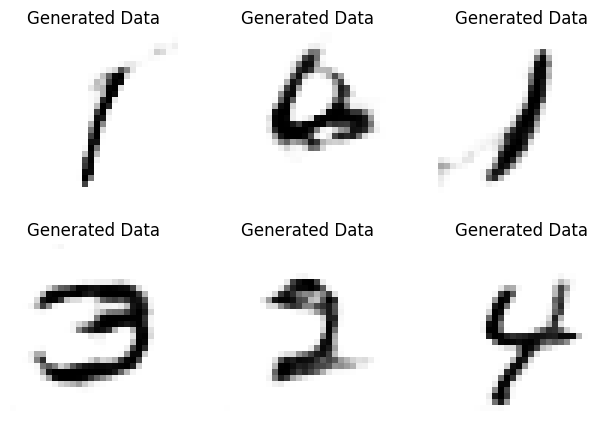

epoch 33
sample_imgs.size(0) 64


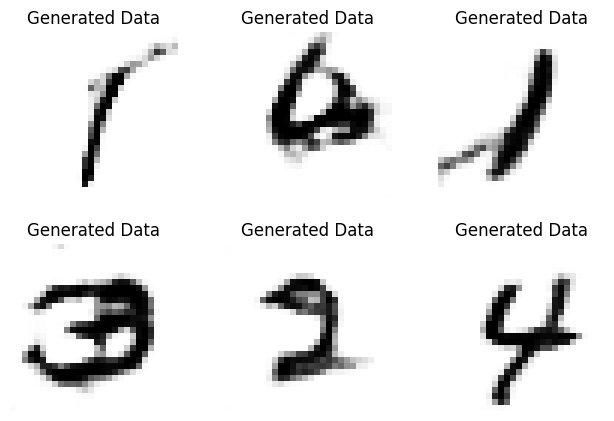

epoch 34
sample_imgs.size(0) 64


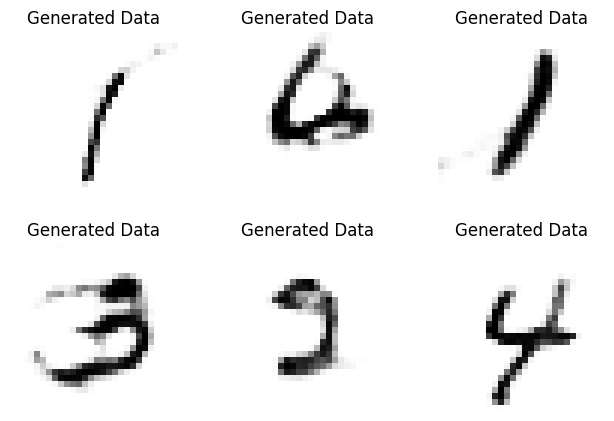

epoch 35
sample_imgs.size(0) 64


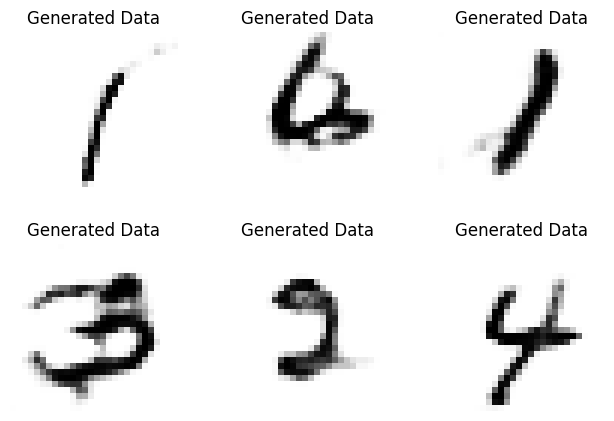

epoch 36
sample_imgs.size(0) 64


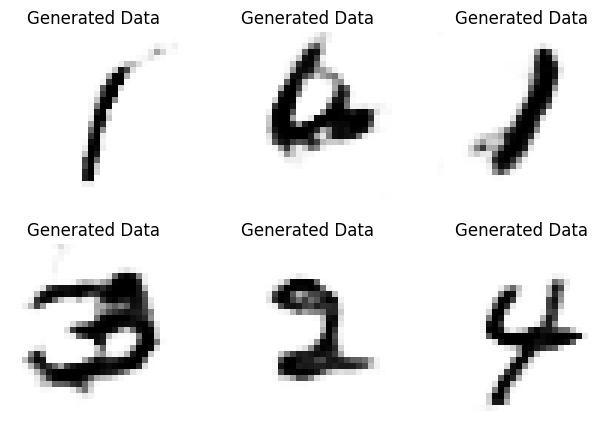

epoch 37
sample_imgs.size(0) 64


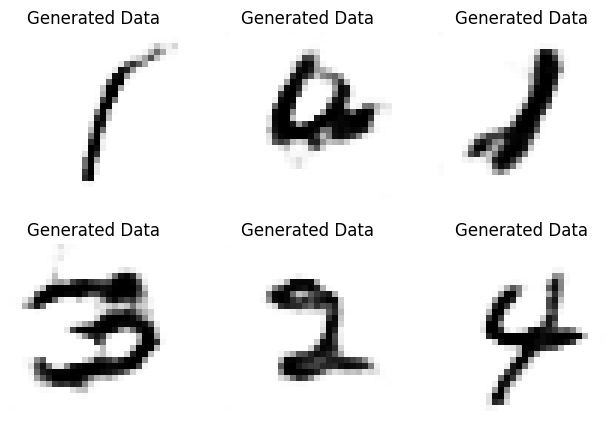

epoch 38
sample_imgs.size(0) 64


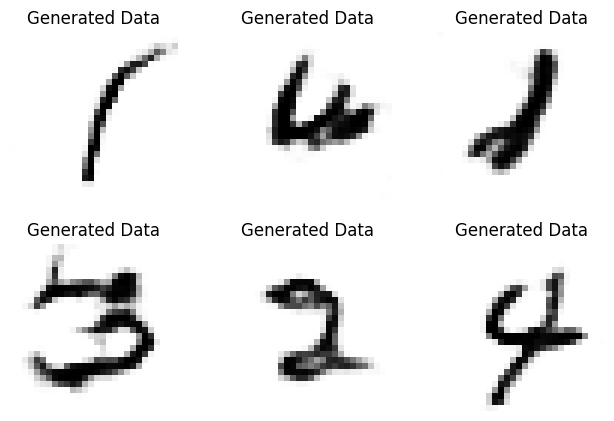

epoch 39
sample_imgs.size(0) 64


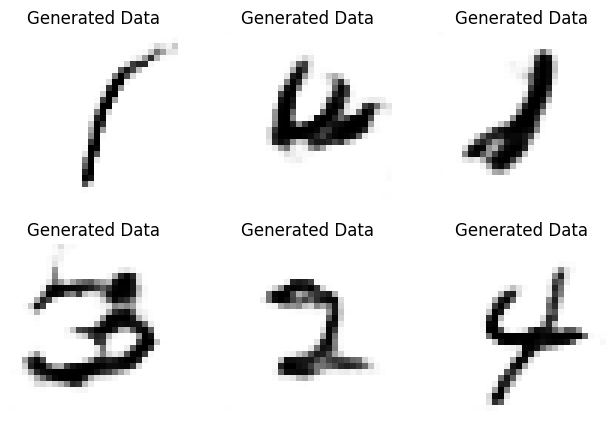

epoch 40
sample_imgs.size(0) 64


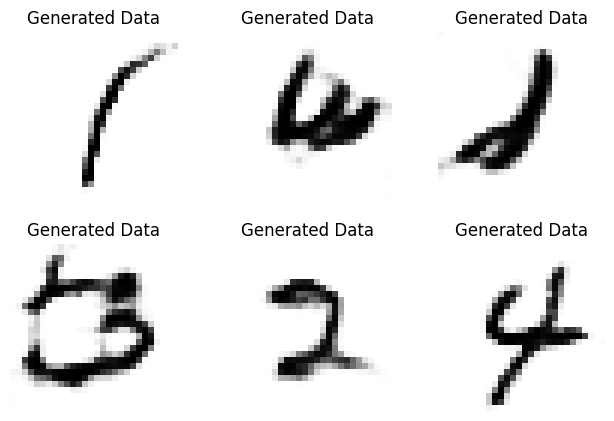

epoch 41
sample_imgs.size(0) 64


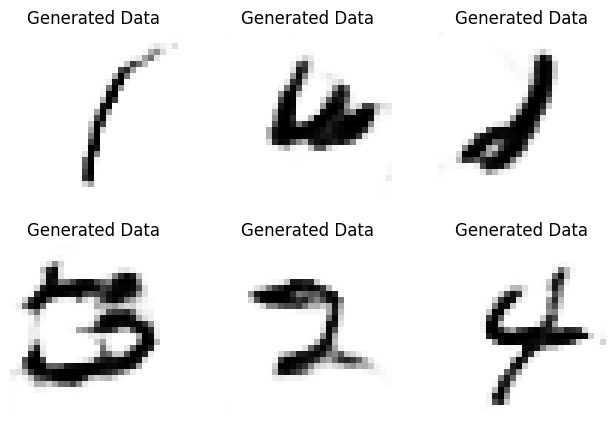

epoch 42
sample_imgs.size(0) 64


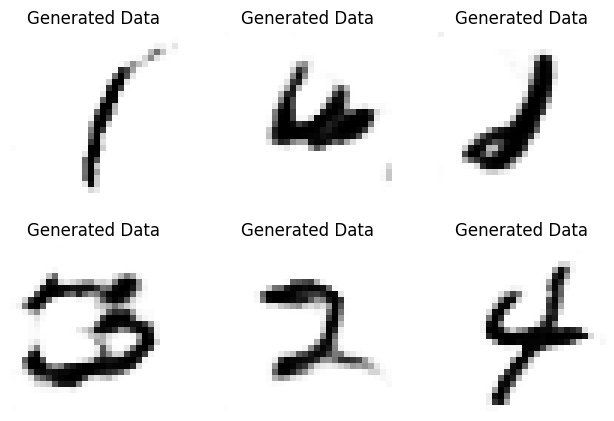

epoch 43
sample_imgs.size(0) 64


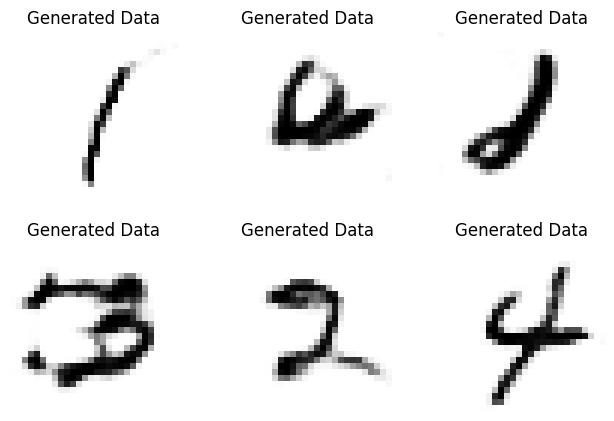

epoch 44
sample_imgs.size(0) 64


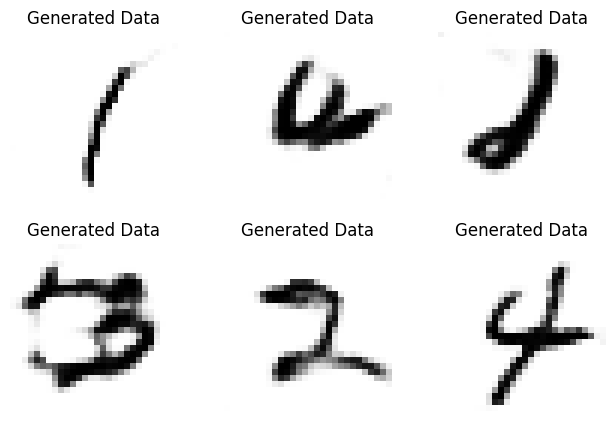

epoch 45
sample_imgs.size(0) 64


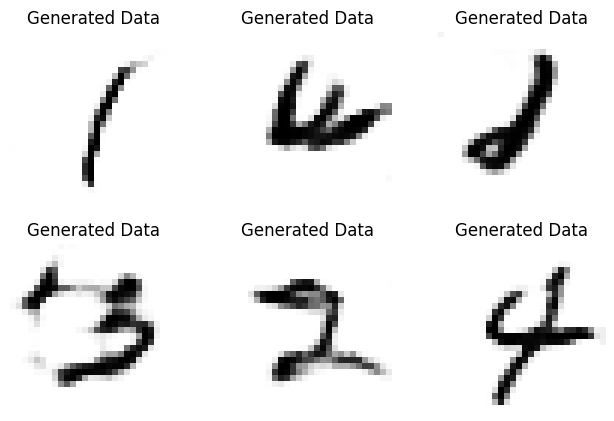

epoch 46
sample_imgs.size(0) 64


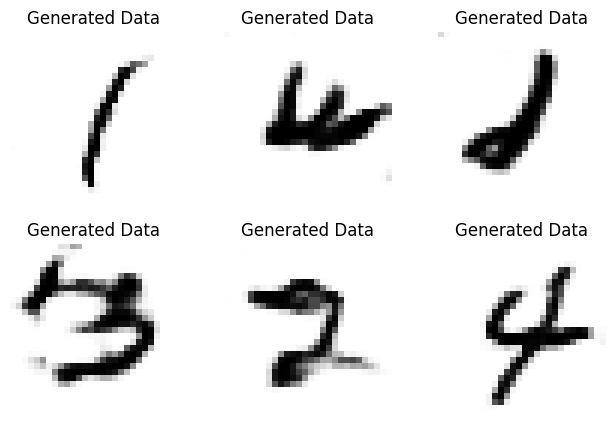

epoch 47
sample_imgs.size(0) 64


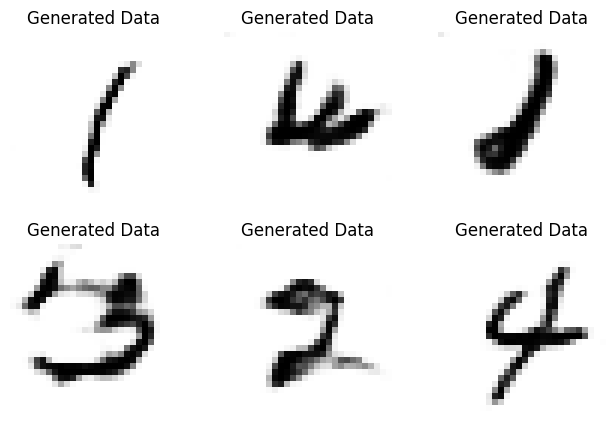

epoch 48
sample_imgs.size(0) 64


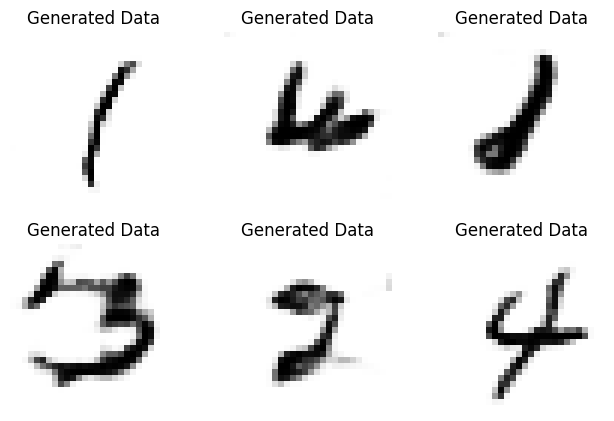

epoch 49
sample_imgs.size(0) 64


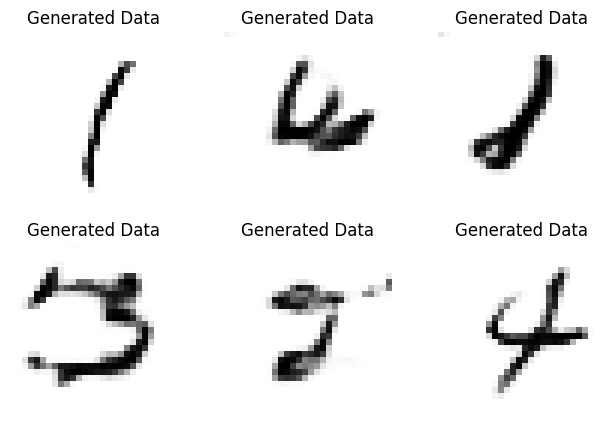

In [15]:
trainer = pl.Trainer(accelerator='gpu', devices=AVAIL_GPUS, max_epochs=50)
trainer.fit(model, data_module)

### Sampling from the model

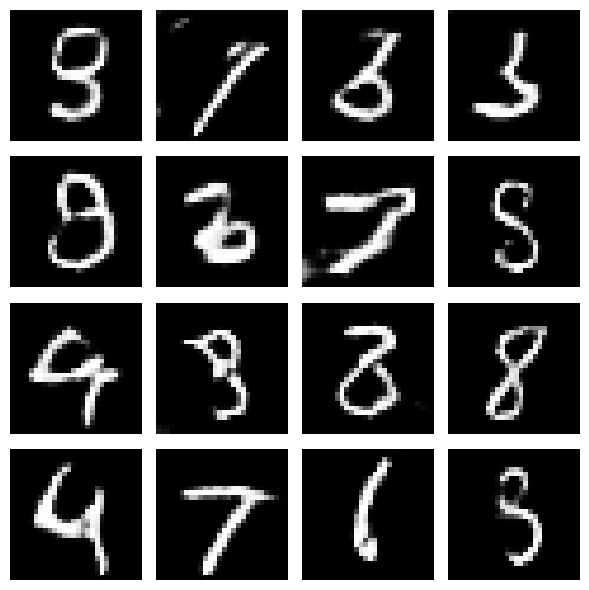

In [16]:
# Set model to eval mode
model.eval()

# Number of samples
num_samples = 16
latent_dim = model.hparams.latent_dim

# Sample random noise
z = torch.randn(num_samples, latent_dim).to(model.device)

# Generate fake images
with torch.no_grad():
    fake_images = model(z)

# fake_images will be shape [N, 1, 28, 28], with values in [-1, 1]

grid_size = int(num_samples ** 0.5)
fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        img = fake_images[idx].cpu().squeeze().numpy()
        img = (img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()